<a href="https://colab.research.google.com/github/KBLin1996/Advertise_Click_Prediction/blob/master/Assignment2_BERT_and_FiLM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Movies - Images and Text -- Assignment [10pts]**

In this assignment, we will be dealing with a significantly larger and more realistic dataset consisting of both images and text. For this assignment we will use the MMIMDB dataset (https://github.com/johnarevalo/gmu-mmimdb), collected by Arévalo, González, Solorio and Montes-y-Gómez from the Universidad Nacional de Colombia, University of Houston, INAOE-México. This dataset contains data corresponding to ~26,000 movies along with their plots (text) and their movie posters (images), and other information such as ratings and genres (categories). These are more movies than we will watch in a lifetime. We will use this dataset for movie genre classification. Each movie can be labeled with 27 categories of movies.

#### **1. Loading and Exploring the Dataset.**

##### **1.1 Dataset Download and Extraction**

First, we download the dataset, then we will create a Dataset class to load both the input movie posters (images), and input movie plots (texts), and the target movie genres (labels). We will also integrate the BertTokenizer from the huggingface transformers library so that the texts are pre-tokenized as they are loaded. The images however will be loaded on the fly as they can not all fit into memory.

In [ ]:
!wget -nc http://www.cs.rice.edu/~vo9/vislang/mmimdb-256.tar.gz
#!wget -nc http://www.cs.virginia.edu/~vicente/vislang/mmimdb-256.tar.gz
# I found downloading from Google/ Drive with gdown is a lot faster.
!pip -q install gdown
#!gdown https://drive.google.com/uc?id=173IhB80sQj2QfzTa10EsoUeEirb7LLlE
!tar xf mmimdb-256.tar.gz
#!tar xf mmimdb-512.tar.gz # I also keep a copy with images resized at 512 pixels on their largest side.
!pip install livelossplot --quiet
!pip -q install transformers

--2022-02-27 19:07:24--  http://www.cs.rice.edu/~vo9/vislang/mmimdb-256.tar.gz
Resolving www.cs.rice.edu (www.cs.rice.edu)... 128.42.207.26
Connecting to www.cs.rice.edu (www.cs.rice.edu)|128.42.207.26|:80... connected.
HTTP request sent, awaiting response... 302 Found : Moved Temporarily
Location: https://www.cs.rice.edu/~vo9/vislang/mmimdb-256.tar.gz [following]
--2022-02-27 19:07:24--  https://www.cs.rice.edu/~vo9/vislang/mmimdb-256.tar.gz
Connecting to www.cs.rice.edu (www.cs.rice.edu)|128.42.207.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 643479473 (614M) [application/x-gzip]
Saving to: ‘mmimdb-256.tar.gz’

mmimdb-256.tar.gz   100%[===================>] 613.67M  5.54MB/s    in 1m 51s  

2022-02-27 19:09:16 (5.51 MB/s) - ‘mmimdb-256.tar.gz’ saved [643479473/643479473]

     |████████████████████████████████| 3.5 MB 5.3 MB/s 
     |████████████████████████████████| 596 kB 48.2 MB/s 
     |████████████████████████████████| 6.8 MB 17.6 MB/s 
     |████

##### **1.2 Defining the Data Loader**
This is a typical step in your course project that you will need to complete. Find some dataset, define your task, then get to know your data well enough so that you can write a data loader for it. Don't take this work for granted. It is hard work. Please take some time analyzing the code below and if you have questions feel free to ask on Piazza. Play especially close attention to the part of the code used for tokenizing the text. This is a special preprocessing step in NLP that doesn't typically apply to images.

In [1]:
import torch, os, json
import matplotlib.pyplot as plt
from transformers import BertTokenizer
from PIL import Image

class MovieDataset(torch.utils.data.Dataset):
    def __init__(self, folder = 'dataset-resized-256max', split = 'dev',
                 image_transform = None):
        self.json_dir = os.path.join(folder, split, 'metadata')
        self.image_dir = os.path.join(folder, split, 'images')
        self.image_transform = image_transform
        # This will download the pretrained BertTokenizer
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

        # Category definitions of movies.
        self.categories = ['Action', 'Adult', 'Adventure', 'Animation', 'Biography', 
                           'Comedy', 'Crime', 'Documentary', 'Drama', 
                           'Family', 'Fantasy', 'Film-Noir', 'History', 
                           'Horror', 'Music', 'Musical', 'Mystery', 'News', 
                           'Reality-TV', 'Romance', 'Sci-Fi', 'Short', 
                           'Sport', 'Talk-Show', 'Thriller', 'War', 'Western']
        self.categories2ids = {category: id for (id, category) 
                               in enumerate(self.categories)}

        # Load JSON files.
        print('Loading %s ...' % self.json_dir, end = '')
        fdir = os.listdir(self.json_dir)
        self.metadata = [(fname[:-5], json.load(open(os.path.join(self.json_dir, fname)))) 
                     for fname in sorted(fdir) if not fname.startswith('.')]
        print(' finished')

        # Pre-tokenizing all sentences.
        print('Tokenizing...', end = '')
        self.tokenized_plots = list()
        for i in range(0, len(self.metadata)):
            text = self.metadata[i][1]['plot'][0]
            # Method to generally tokenize it in projects:
            # [Parameters]
            # truncation => as BERT can only accept/take as input only 512 tokens at a time, we must specify the truncation parameter to True
            # add_special_tokens => is just for BERT to add tokens like the start, end, [SEP], and [CLS] tokens
            # return_tensors=“pt” => is just for the tokenizer to return PyTorch tensors. If you don’t want this to happen(maybe you want it to return a list), then you can remove the parameter and it will return lists
            # return_attention_mask => The attention mask is a binary tensor indicating the position of the padded indices so that the model does not attend to them.
            encoded_text = self.tokenizer.encode_plus(
                text, add_special_tokens = True, truncation = True, 
                max_length = 256, padding = 'max_length',
                return_attention_mask = True,
                return_tensors = 'pt')
            self.tokenized_plots.append(encoded_text)
        print(' finished')
            
    def __getitem__(self, index: int):
        # Load images on the fly.
        filename, movie_data = self.metadata[index]
        img_path = os.path.join(self.image_dir, filename + '.jpeg')
        image = Image.open(img_path).convert('RGB')
        # text => tensor([[ ... ]]) contains text ids in the tokenizers
        text = self.tokenized_plots[index]['input_ids'][0]
        text_mask = self.tokenized_plots[index]['attention_mask'][0]
        genres = movie_data['genres']

        if self.image_transform: image = self.image_transform(image)

        # Encode labels in a binary vector.
        label_vector = torch.zeros((len(self.categories)))
        # Record all of the categories in genres into label_vector
        label_ids = [self.categories2ids[cat] for cat in genres]
        label_vector[label_ids] = 1

        return image, text, text_mask, label_vector

    def load_image_only(self, index: int):
        filename, movie_data = self.metadata[index]
        img_path = os.path.join(self.image_dir, filename + '.jpeg')
        image = Image.open(img_path).convert('RGB')
        return image

    def get_metadata(self, index: int):
        _, movie_data = self.metadata[index]
        return movie_data

    def __len__(self):
        return len(self.metadata)

val_data = MovieDataset(split = 'dev')
print('Data size: %d samples' % len(val_data))

Loading dataset-resized-256max/dev/metadata ... finished
Tokenizing... finished
Data size: 2608 samples


##### **1.3 Testing the data loader**
Printing one element from this dataset, both the plot, movie poster, labels, and some of the other metadata. Do not move to the following cells until you understand every line in the code above and below.

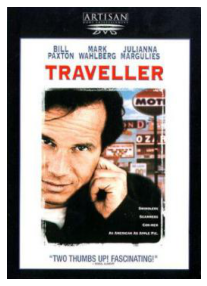

['a', 'young', 'man', ',', 'pat', ',', 'visits', 'the', 'clan', 'of', 'gypsy', '-', 'like', 'gr', '##if', '##ters', '(', 'irish', 'travellers', ')', 'in', 'rural', 'north', 'carolina', 'from', 'whom', 'he', 'is', 'descended', '.', 'he', 'is', 'at', 'first', 'rejected', ',', 'but', 'cousin', 'bo', '##kk', '##y', 'takes', 'him', 'on', 'as', 'an', 'apprentice', '.', 'pat', 'learns', 'the', 'game', 'while', 'bo', '##kk', '##y', 'falls', 'in', 'love', 'and', 'desires', 'a', 'different', 'life', '.']
a young man , pat , visits the clan of gypsy - like grifters ( irish travellers ) in rural north carolina from whom he is descended . he is at first rejected , but cousin bokky takes him on as an apprentice . pat learns the game while bokky falls in love and desires a different life .
['Crime', 'Drama', 'Romance']
Title:  Traveller
Kind:  movie
Year:  1997
Rating:  6.2


In [2]:
import numpy as np

sample_movieID = 1247
img, text, text_mask, labels = val_data[sample_movieID]

# Show input image.
plt.figure(figsize=(4,5)); plt.imshow(img); plt.axis(False); plt.show()

# Show input plot (untokenized).
# tokenizer.convert_ids_to_tokens => (ids, skip_special_tokens: bool = False) → str or List[str]
# ids (int or List[int]) => The token id (or token ids) to convert to tokens
# skip_special_tokens (bool, optional, defaults to False) => Whether or not to remove special tokens in the decoding
tokens = val_data.tokenizer.convert_ids_to_tokens(text, skip_special_tokens = True)
print(tokens)
print(val_data.tokenizer.convert_tokens_to_string(tokens))

# Show target labels (converted back to strings from binary vector).
labels = labels.numpy()
# Is there a better way to do this?
print([val_data.categories[ind] for ind, val in enumerate(labels == 1) if val == 1])

# You can look at other attributes for the movies on this dataset.
movie_metadata = val_data.get_metadata(sample_movieID)
print('Title: ', movie_metadata['smart canonical title'])
print('Kind: ', movie_metadata['kind'])
print('Year: ', movie_metadata['year'])
print('Rating: ', movie_metadata['rating'])

##### **1.4 Visualizing a group of samples**
We explore below some of the images in the dataset that belong to the category `Comedy`.

There are 873 movies of type Comedy among 2608


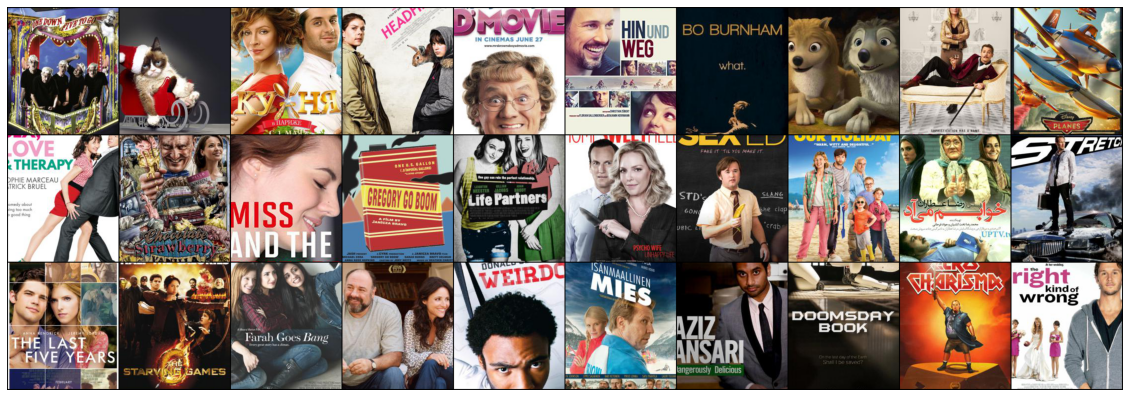

In [ ]:
import torchvision
import torchvision.transforms.functional as F
import torchvision.transforms as transforms

# Now let's display a bunch of posters for Crime movies.
movieType = 'Comedy'
crime_ids = [id for id in range(0, len(val_data)) \
             if movieType in set(val_data.get_metadata(id)['genres'])]

print('There are %d movies of type %s among %d' % 
      (len(crime_ids), movieType, len(val_data)))

def show_image_group(dataset, image_ids, n_images):
    image_ids = image_ids[:n_images]
    # transforms.CenterCrop => Crops the given image at the center. If image size is smaller than output size along any edge, image is padded with 0 and then center cropped.
    Transf = transforms.Compose([transforms.CenterCrop((256, 224)), transforms.ToTensor()])
    imgs = [Transf(dataset.load_image_only(id)) for id in image_ids]
    grid = torchvision.utils.make_grid(imgs, nrow = 10)
    plt.figure(figsize=(20,10)); plt.axis(False)
    plt.imshow(F.to_pil_image(grid));

# I'm passing the ids in reverse order, because it seems the movies are
# ordered from old to new in the dataset. Try the other way.
# reverse reverses the list in-place, while [::-1] gives a new list in reversed order.
show_image_group(val_data, crime_ids[::-1], 30)

#### **2. Classify the Movies into Genres (based on their Plots -- Text) [2pts]**

For this assignment we will not just use BERT encodings but we will use a pretrained BERT model and "fine-tune" its parameters to they adapt to the text in this dataset. This is commonly referred as transfer learning. You can try compare it to a simpler bag-of-words model but this is left as an exercise on your own.

##### **2.1. Setting up Data Loaders**

In the code below, we are loading the training, and validation splits and then testing the batch loaders.

In [3]:
# Let's setup the data loaders and preprocessing.
import torchvision.transforms as transforms

# Batch size is a liming factor on constrained resources.
# only GPUs with a large memory can hold large batches.
batch_size = 10

image_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])])

trainset = MovieDataset(split = 'train', image_transform = image_transform)
valset = MovieDataset(split = 'dev', image_transform = image_transform)

# If you load your samples in the Dataset on CPU and would like to push it during training to the GPU, you can speed up the host to device transfer by enabling pin_memory.
# This lets your DataLoader allocate the samples in page-locked memory, which speeds-up the transfer.
train_loader = torch.utils.data.DataLoader(trainset, 
                                           batch_size = batch_size, 
                                           shuffle = True, 
                                           pin_memory = True,
                                           num_workers = 2)
val_loader = torch.utils.data.DataLoader(valset, 
                                         batch_size = batch_size, 
                                         shuffle = False)

Loading dataset-resized-256max/train/metadata ... finished
Tokenizing... finished
Loading dataset-resized-256max/dev/metadata ... finished
Tokenizing... finished


Testing what a sample batch looks like.

In [4]:
# iter() => convert list to iterator
# next() => the next element is the first element, then the second, then the third, ...
(imgs, texts, text_masks, labels) = next(iter(val_loader))
print(imgs.shape, texts.shape, text_masks.shape, labels.shape)

torch.Size([10, 3, 224, 224]) torch.Size([10, 256]) torch.Size([10, 256]) torch.Size([10, 27])


##### **2.2. Loading the predefined BERT Transformer Model**

Here we initialize the pretrained BERT model from the huggingface transformers library. They have several slightly different versions of it that are slightly modified for different tasks so you don't need to manually modify it (e.g. replacing last layer with something else) for your particular task. Do not be surprised if Google Colab keeps crashing. This is a very heavy model so I would recommend only running this cell once. Or if you have to run it twice, you might have to restart the runtime.

In [ ]:
from transformers import BertForSequenceClassification, BertConfig

# Loading BERT...
num_categories = len(trainset.categories)
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', 
    num_labels = num_categories,  output_attentions = False, 
    output_hidden_states = False)

# Let's run a quick test on this model on the CPU.
output = model(texts, text_masks)
print(output.logits.shape)

# Tell pytorch to run this model on the GPU.
model.cuda();

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

torch.Size([10, 27])


##### **2.3. Training Loop for finetuning this BERT Model**
Not very different than a training loop for training a model based on convolutional neural networks. However, please pay close attention to the differences. 

In [ ]:
from transformers import get_linear_schedule_with_warmup
from livelossplot import PlotLosses
import torch.nn as nn

num_epochs = 1

# Following recommendations from the BERT paper and also this
# blog post https://mccormickml.com/2019/07/22/BERT-fine-tuning/
optimizer = torch.optim.AdamW(model.parameters(), lr = 2e-5, eps = 1e-8)

# Total number of training steps is [number of batches] * [number of epochs]. 
# (Note that this is not the same as the number of training samples)
total_steps = len(train_loader) * num_epochs

# Create the learning rate scheduler
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps = 0, num_training_steps = total_steps)

# Binary Cross-Entroy Loss (BCE Loss).
# Please see documentation here:
# https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html

# This loss combines a Sigmoid layer and the BCELoss in one single class
cost_function = nn.BCEWithLogitsLoss(reduction = 'none')

# Are the top five scored labels accurate?
def top5_accuracy(predicted, labels):
    sorted_vals, sorted_ids = \
        predicted.data.sigmoid().sort(dim = 1, descending = True)
    pred_vals = sorted_vals[:, :5] > 0.5 # Anything with sigmoid > 0.5 is 1.
    true_vals = labels.data.gather(1, sorted_ids[:, :5]) # Find true values.
    return (pred_vals == true_vals).sum(dim = 1) / 5.0

# Training Loop.
best_accuracy = 0
liveloss = PlotLosses(); current_step = 0
for epoch in range(0, num_epochs):
    cumulative_accuracy = 0
    cumulative_loss = 0
    num_samples = 0
    logs = {}
    model.train()
    for (batch_id, (imgs, texts, text_masks, labels)) in enumerate(train_loader):
        # Move to GPU.
        texts = texts.cuda()
        text_masks = text_masks.cuda()
        labels = labels.cuda()

        # Compute predictions.
        # Returns:
        # loss => Language modeling loss (for next-token prediction)
        # logits => Prediction scores of the language modeling head (scores for each vocabulary token before SoftMax)
        predicted = model(texts, text_masks)

        # Compute loss.
        loss = cost_function(predicted.logits, labels)

        # Compute cumulative loss and top-5 accuracy.
        # Returns the value of this tensor as a standard Python number. This only works for tensors with one element.
        cumulative_loss += loss.data.sum().item()
        print(top5_accuracy(predicted.logits, labels).sum())
        cumulative_accuracy += top5_accuracy(predicted.logits, labels).sum().item()
        num_samples += texts.size(0)

        # Backpropagation and SGD update step.
        model.zero_grad()
        loss.mean().backward()
        optimizer.step()
        
        if batch_id % 100 == 0:
            print(epoch, batch_id, cumulative_accuracy / num_samples)
            logs['loss'] = cumulative_loss / num_samples
            logs['accuracy'] = cumulative_accuracy / num_samples
            liveloss.update(logs)
            liveloss.send()
            current_step += 1
    
    cumulative_accuracy = 0
    cumulative_loss = 0
    num_samples = 0
    model.eval()
    for (batch_id, (imgs, texts, text_masks, labels)) in enumerate(val_loader):
        # Move to GPU.
        texts = texts.cuda()
        text_masks = text_masks.cuda()
        labels = labels.cuda()

        # Compute predictions.
        predicted = model(texts, text_masks)

        # Compute loss.
        loss = cost_function(predicted.logits, labels)

        # Compute cumulative loss and top-5 accuracy.
        cumulative_loss += loss.data.sum().item()
        cumulative_accuracy += top5_accuracy(predicted.logits, labels).sum().item()
        num_samples += texts.size(0)

        if (1 + batch_id) % 100 == 0:
            logs['val_loss'] = cumulative_loss / num_samples
            logs['val_accuracy'] = cumulative_accuracy / num_samples    
            liveloss.update(logs, current_step)
            liveloss.send()

    # Advance scheduler.
    if scheduler != -1:
        scheduler.step()

    # Save the parameters for the best accuracy on the validation set so far.
    if logs['val_accuracy'] > best_accuracy:
        best_accuracy = logs['val_accuracy']
        torch.save(model.state_dict(), 'best_model_so_far.pth') 

TypeError: ignored

##### **2.4. Loading model weights from a file**
Training the model in the previous section might take about an hour -- instead we can load a model that has been pretrained already. Feel free to retrain but here I provide a model I trained myself by running the code in the preceding section.

In [ ]:
# I uploaded a "checkpoint" of this model that I trained on Google Drive.
# Try saving and uploading your model to Google Drive as well.
#!gdown https://drive.google.com/uc?id=1WuLFvQLMd0_Nmpjp7aDRIovWtOiRRyRd
#model.load_state_dict(torch.load('best_model_so_far.pth'))
model.load_state_dict(torch.load('best_model_so_far-comp646-spring2022.pth'))
model.eval();

RuntimeError: ignored

##### **2.5 Show the predictions for a few input texts [1pt]**
Show the top five classification predictions of the BERT model for a few input plots, as shown below. In order to obtain probability scores you need to understand what the nn.BCEWithLogitsLoss is doing when training the prediction scores. Take into account that since we are dealing with multi-class classification, this is not a softmax classifier trained with a cross entropy loss (nn.CrossEntropyLoss), ie. prediction scores don't add up to 1.

In [ ]:
# Your code goes here.
import numpy as np

sample_movieID = 3
img, text, text_mask, labels = val_data[sample_movieID]


# Show input plot (untokenized).
# tokenizer.convert_ids_to_tokens => (ids, skip_special_tokens: bool = False) → str or List[str]
# ids (int or List[int]) => The token id (or token ids) to convert to tokens
# skip_special_tokens (bool, optional, defaults to False) => Whether or not to remove special tokens in the decoding
tokens = val_data.tokenizer.convert_ids_to_tokens(text, skip_special_tokens = True)

# Print the text of the sample movie
print("--output included with assignment--\n")
print("##################                        INPUT                        ##################\n#########################################################################################")

outputText = val_data.tokenizer.convert_tokens_to_string(tokens)
outputString = ""

sampleLen = len("k on the defenses of fortress europe as well as his part in the assassination at")

cnt = 0
for i in outputText:
    cnt += 1
    if cnt == sampleLen:
        outputString += "\n"
        cnt = 0
    outputString += i

print(f'"{outputString}"')
print("#########################################################################################")


batch_size = 10
test_loader = torch.utils.data.DataLoader(valset, 
                                         batch_size = batch_size, 
                                         shuffle = False)


for (batch_id, (imgs, texts, text_masks, labels)) in enumerate(test_loader):
    # Move to GPU.
    #texts = texts.cuda()
    #text_masks = text_masks.cuda()
    #labels = labels.cuda()

    # Compute predictions.
    # Returns:
    # loss => Language modeling loss (for next-token prediction)
    # logits => Prediction scores of the language modeling head (scores for each vocabulary token before SoftMax)
    predicted = model(texts, text_masks)

    # Compute cumulative loss and top-5 accuracy.
    # Returns the value of this tensor as a standard Python number. This only works for tensors with one element.
    if batch_id == 0:
        sorted_vals, sorted_ids = predicted.logits.data.sigmoid().sort(dim = 1, descending = True)

        for i in range(5):
            score = "{:.2f}".format(sorted_vals[sample_movieID][i].item())
            # print(sorted_ids[i])
            print(f"P[{val_data.categories[sorted_ids[sample_movieID][i].item()]}] = {score}")

        idx = sorted_ids[sample_movieID][:5].tolist()
        groundTruth = []

        for i in idx:
            if labels[sample_movieID][i] == 1:
                groundTruth.append(val_data.categories[i])

        print(f"Ground Truth Labels: {groundTruth}")

        break

--output included with assignment--

##################                        INPUT                        ##################
#########################################################################################
"fantomas makes it as the emperor of crime . first is the robbery at the royal p
alace hotel . then he abducts lord beltham . as fantomas ' fame increases actor 
valgrand creates the role of public enemy no . 1 on stage . eventually inspector
 juve , with a little help from fandor , arrests fantomas and he is soon sentenc
ed to die on the guillotine . but . . ."
#########################################################################################
P[Comedy] = 0.92
P[Crime] = 0.63
P[Thriller] = 0.18
P[Mystery] = 0.12
P[Drama] = 0.11
Ground Truth Labels: ['Crime', 'Drama']


##### **2.6. Show the posters for movies labeld as Comedy with the highest confidence by the BERT model. [1pt]**

Use the show_image_group function provided earlier to show the top 30 images scored with the highest scores by the BERT model as Comedy. **Note:** I know the model is not scoring the movies based on the movie poster at all but it seems easier to judge by movie poster for a quick visual inspection as it doesn't require reading text.

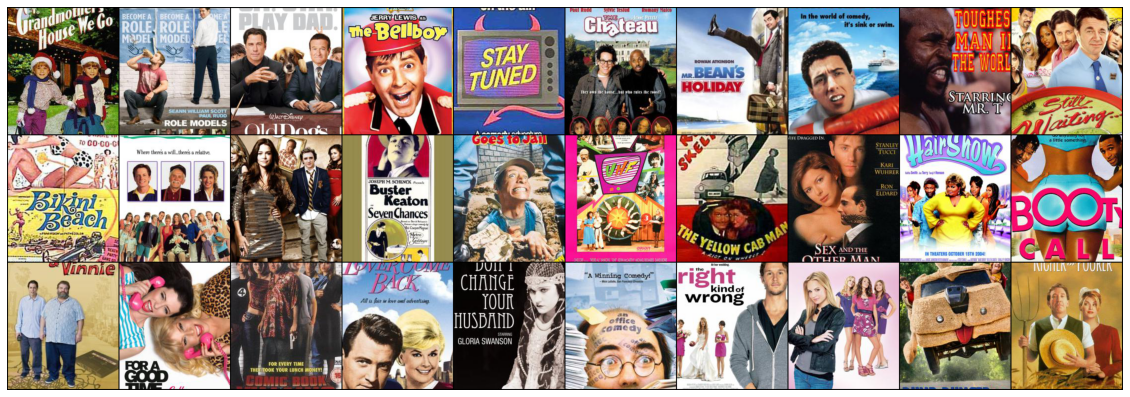

In [ ]:
# Your code goes here.

import torchvision
import torchvision.transforms.functional as F
import torchvision.transforms as transforms

movieType = 'Comedy'

batch_size = 10
val_loader = torch.utils.data.DataLoader(valset, 
                                         batch_size = batch_size, 
                                         shuffle = False)

comedyScore = {}
comedyIdx = val_data.categories2ids[movieType]
for (batch_id, (imgs, texts, text_masks, labels)) in enumerate(val_loader):
    # Move to GPU.
    texts = texts.cuda()
    text_masks = text_masks.cuda()
    labels = labels.cuda()

    # Compute predictions.
    predicted = model(texts, text_masks)

    vals = predicted.logits.data.sigmoid()

    for i in range(len(vals)):
        idx = i + batch_id * batch_size
        comedyScore[idx] = vals[i][comedyIdx].item()


# Now let's display a bunch of posters for Comedy movies.
def show_image_group(dataset, image_ids, n_images):
    image_ids = image_ids[:n_images]
    # transforms.CenterCrop => Crops the given image at the center. If image size is smaller than output size along any edge, image is padded with 0 and then center cropped.
    Transf = transforms.Compose([transforms.CenterCrop((256, 224)), transforms.ToTensor()])
    imgs = [Transf(dataset.load_image_only(id)) for id in image_ids]
    grid = torchvision.utils.make_grid(imgs, nrow = 10)
    plt.figure(figsize=(20,10)); plt.axis(False)
    plt.imshow(F.to_pil_image(grid));


# Sort the comedy scores of the validation dataset from big to small
comedyScore = dict(sorted(comedyScore.items(), key=lambda item: item[1], reverse=True))

# Get the keys and turn it into a list (idx from large score to small)
comedySortedIdx = list(comedyScore.keys())
show_image_group(val_data, comedySortedIdx, 30)

#### **3. Classify the Movies into Genres (based on their Posters -- Images) [4pts]**



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Feel free to discuss answers to these questions or share plots on Piazza -- but not code. Also I'm setting here a leaderboard again for this task [here](https://docs.google.com/spreadsheets/d/1p7ly7-VC3WiI5mtsy-xKfHVu8cwaYK1Eovmysfnasws/edit?usp=sharing). Please share your results so that your classmates know where their solution lies with respect to the rest of the class.

##### **3.1 Training the model [2pts]**
For this part feel free to re-use code from the previous sections, the previous assignment, and the previous assignment solutions, as appropriate. You have to at least show your training/validation accuracy and loss plots showing the model is learning and has converged.

In [ ]:
# Your code goes here.

# Include here any necessary code to define and setup your model.
from torch import nn
from torchvision import models

output_class = 27
#model = models.vgg16(pretrained=True)
#model.classifier._modules['6'] = nn.Linear(4096, output_class)

#model = models.densenet161(pretrained=True, progress=True)
#model.classifier = nn.Linear(1024, output_class)
#print(model.features)

model = models.inception_v3(pretrained=True)
model.AuxLogits.fc = nn.Linear(768, output_class)
model.fc = nn.Linear(2048, output_class)
model.cuda()

count_params = 0
for param in model.parameters():
  count_params += param.numel()
print(count_params)

In [ ]:
!pip install livelossplot --quiet
from livelossplot import PlotLosses

# Defining as global the device to use (by default CPU).
device = torch.device("cuda")


# Are the top five scored labels accurate?
def top5_accuracy(predicted, labels):
    sorted_vals, sorted_ids = predicted.data.sigmoid().sort(dim = 1, descending = True)
    pred_vals = sorted_vals[:, :5] > 0.5 # Anything with sigmoid > 0.5 is 1.
    true_vals = labels.data.gather(1, sorted_ids[:, :5]) # Find true values.
    return (pred_vals == true_vals).sum(dim = 1) / 5.0


def train_model(batch_size, 
                n_epochs, 
                learningRate, 
                model, 
                cost_function, 
                optimizer,
                scheduler,
                train_loader,
                val_loader):

  # Move the model and cost function to GPU (if needed).
  model = model.to(device)
  cost_function = cost_function.to(device)

  # Keep track of best accuracy so far.
  current_step = 0
  best_accuracy = 0
  liveloss = PlotLosses()

  # Main for loop of SGD.
  for epoch in range(0, n_epochs):
    logs = {}

    # initialize control variables.
    correct = 0
    cumulative_accuracy = 0
    cumulative_loss = 0
    num_samples = 0

    # Set the model in training mode.
    model.train()

    # Sample a batch on each iteration.
    for (batch_id, (imgs, texts, text_masks, labels)) in enumerate(train_loader):
        # Move to GPU.
        imgs = imgs.to(device)
        labels = labels.to(device)

        # Compute predictions.
        # Returns:
        # loss => Language modeling loss (for next-token prediction)
        # logits => Prediction scores of the language modeling head (scores for each vocabulary token before SoftMax)
        predicted = model(imgs)

        # Compute loss.
        loss = cost_function(predicted.logits, labels)

        # Compute cumulative loss and top-5 accuracy.
        # Returns the value of this tensor as a standard Python number. This only works for tensors with one element.
        cumulative_loss += loss.data.sum().item()
        cumulative_accuracy += top5_accuracy(predicted.logits, labels).sum().item()
        num_samples += texts.size(0)

        # Backpropagation and SGD update step.
        model.zero_grad()
        loss.mean().backward()
        optimizer.step()
        
        if batch_id % 100 == 0:
            print(epoch, batch_id, cumulative_accuracy / num_samples)
            logs['loss'] = cumulative_loss / num_samples
            logs['accuracy'] = cumulative_accuracy / num_samples
            liveloss.update(logs)
            liveloss.send()
            current_step += 1


    # Run the model on the validation set to keep track of accuracy there.
    cumulative_accuracy = 0
    cumulative_loss = 0
    num_samples = 0

    model.eval()
    # No need to keep track of gradients for this part.
    with torch.no_grad():
        for (batch_id, (imgs, texts, text_masks, labels)) in enumerate(val_loader):
            # Move to GPU.
            imgs = imgs.to(device)
            labels = labels.to(device)

            # Compute predictions.
            predicted = model(imgs)

            # Compute loss.
            loss = cost_function(predicted, labels)

            # Compute cumulative loss and top-5 accuracy.
            cumulative_loss += loss.data.sum().item()
            cumulative_accuracy += top5_accuracy(predicted, labels).sum().item()
            num_samples += texts.size(0)

            if (1 + batch_id) % 100 == 0:
                print("Val Log")
                logs['val_loss'] = cumulative_loss / num_samples
                logs['val_accuracy'] = cumulative_accuracy / num_samples    
                liveloss.update(logs, current_step)
                liveloss.send()


    # Advance scheduler.
    if scheduler != -1:
        scheduler.step()

    # Save the parameters for the best accuracy on the validation set so far.
    if logs['val_accuracy'] > best_accuracy:
        best_accuracy = logs['val_accuracy']
        torch.save(model.state_dict(), 'best_model_so_far.pth')   

In [ ]:
# Your training code goes here.

import torch.optim
import torchvision.transforms as transforms

batch_size = 10
n_epochs = 3
learningRate = 1e-3

# Basic SGD Optimizer.
optimizer = torch.optim.SGD(model.parameters(), lr = learningRate)

# torch.nn.BCEWithLogitsLoss applies the binary predictions of each category.
cost_function = nn.BCEWithLogitsLoss(reduction = 'none')

image_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop((299, 299)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])])

trainset = MovieDataset(split = 'train', image_transform = image_transform)
valset = MovieDataset(split = 'dev', image_transform = image_transform)

train_loader = torch.utils.data.DataLoader(trainset, 
                                           batch_size = batch_size, 
                                           shuffle = True, 
                                           pin_memory = True,
                                           num_workers = 2)
val_loader = torch.utils.data.DataLoader(valset, 
                                         batch_size = batch_size, 
                                         shuffle = False)

Loading dataset-resized-256max/train/metadata ...['._0279250.json', '._0064146.json', '._1149363.json', '0076100.json', '0850669.json', '0217107.json', '._1284028.json', '0056625.json', '0208092.json', '0129924.json', '._0026071.json', '1592281.json', '._0046511.json', '._2536846.json', '._0040761.json', '._0133189.json', '._0044518.json', '._1691917.json', '0221111.json', '._0017048.json', '._0038873.json', '._0296572.json', '0062782.json', '0036376.json', '._1690140.json', '0284929.json', '._0235198.json', '0084117.json', '1748122.json', '0872230.json', '._0120857.json', '._0061758.json', '1384927.json', '._0093133.json', '0910852.json', '0065547.json', '._0212815.json', '._1663321.json', '2316411.json', '2106671.json', '0177888.json', '0221023.json', '0109040.json', '._0076731.json', '._0029192.json', '0032325.json', '0068970.json', '0189764.json', '._0402115.json', '0118964.json', '._0099091.json', '._2505294.json', '4530184.json', '0068361.json', '._0291502.json', '._0783238.json'

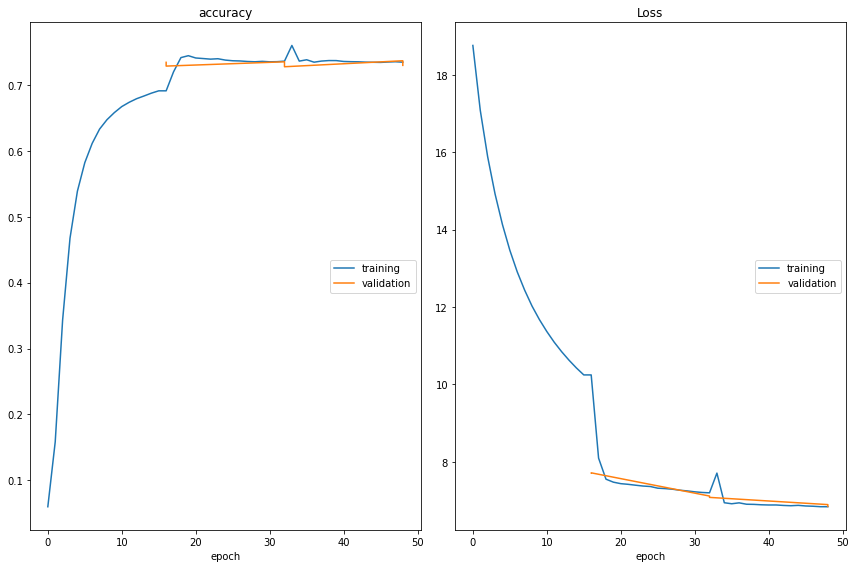

accuracy
	training         	 (min:    0.060, max:    0.760, cur:    0.735)
	validation       	 (min:    0.728, max:    0.737, cur:    0.730)
Loss
	training         	 (min:    6.841, max:   18.759, cur:    6.841)
	validation       	 (min:    6.850, max:    7.717, cur:    6.850)


In [ ]:
train_model(batch_size, n_epochs, learningRate, model, cost_function, optimizer, -1, train_loader, val_loader)

**Required answer:** Is this model better than the text classifier in terms of top-5 accuracy as computed earlier? Which one is better?

**=>** I think the BERT model may provide better prediction on the top-5 accuracy than the image classifier since the validation accuracy of the BERT model is better than the accuracy of the image classification model (0.752 > 0.737). Moreover, I considered that the validation accuracy of the BERT model can be even higher because the current accuracy it stops is same as the maximum accuracy. That is, the validation accuracy could have a better result if we rise the training epoch.

**=>** In addition, in the result of "3.3 Show Predictions", the plot classifier shows a greater prediction of the top-5 results of the sampling movie. It predicts the ground truth absolutely correct within the first two prediction. While the image classifier did predict the ground truth correct in its top-5 predictions, it takes one more guessing to contain all of the ground truth in its prediction.

##### **3.2 Analysis [0.5pt]**
Show the images classified as "Comedy" with the highest confidence using the above image classifier (show their posters).

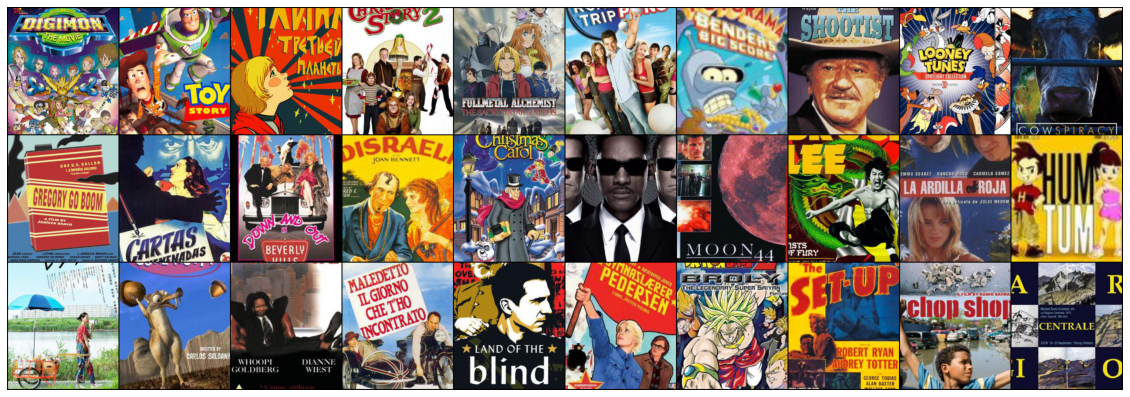

In [ ]:
# Your code goes here.

# I uploaded a "checkpoint" of this model that I trained on Google Drive.
# Try saving and uploading your model to Google Drive as well.
#!gdown https://drive.google.com/uc?id=1WuLFvQLMd0_Nmpjp7aDRIovWtOiRRyRd

model.load_state_dict(torch.load('best_model_so_far.pth'))
model.eval();

import torchvision
import torchvision.transforms.functional as F
import torchvision.transforms as transforms

movieType = 'Comedy'

batch_size = 10
val_loader = torch.utils.data.DataLoader(valset, 
                                         batch_size = batch_size, 
                                         shuffle = False)

comedyScore = {}
comedyIdx = val_data.categories2ids[movieType]
for (batch_id, (imgs, texts, text_masks, labels)) in enumerate(val_loader):
    # Move to GPU.
    imgs = imgs.cuda()
    labels = labels.cuda()

    # Compute predictions.
    predicted = model(imgs)

    vals = predicted.data.sigmoid()

    for i in range(len(vals)):
        idx = i + batch_id * batch_size
        comedyScore[idx] = vals[i][comedyIdx].item()


# Now let's display a bunch of posters for Comedy movies.
def show_image_group(dataset, image_ids, n_images):
    image_ids = image_ids[:n_images]
    # transforms.CenterCrop => Crops the given image at the center. If image size is smaller than output size along any edge, image is padded with 0 and then center cropped.
    Transf = transforms.Compose([transforms.CenterCrop((256, 224)), transforms.ToTensor()])
    imgs = [Transf(dataset.load_image_only(id)) for id in image_ids]
    grid = torchvision.utils.make_grid(imgs, nrow = 10)
    plt.figure(figsize=(20,10)); plt.axis(False)
    plt.imshow(F.to_pil_image(grid));


# Sort the comedy scores of the validation dataset from big to small
comedyScore = dict(sorted(comedyScore.items(), key=lambda item: item[1], reverse=True))

# Get the keys and turn it into a list (idx from large score to small)
comedySortedIdx = list(comedyScore.keys())
show_image_group(val_data, comedySortedIdx, 30)

##### **3.3 Show Predictions [0.5pt]**
For a given movie, show its plot, poster, and the predictions of the plot classifier and the poster classifier.

--output included with assignment--

##################                        INPUT                        ##################
#########################################################################################
"mckinley b . " mac " thompson , american reporter in moscow , smuggles out unce
nsored news under the alias " comrade x , " but hotel valet vanya discovers his 
secret . vanya fears for the safety of his daughter golubka ( " theodore " ) and
 blackmails mac into helping her leave the country . mac is happier about his ta
sk once he meets lovely theodore , but can he convince her of his sincerity ? th
e anti - communist humor becomes alternately grim and farcical ."
#########################################################################################



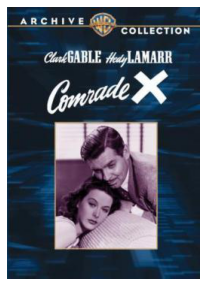

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


######    Predictions of the Plot Classifier    ######
P[Drama] = 0.95
P[Romance] = 0.66
P[Comedy] = 0.13
P[Biography] = 0.05
P[Thriller] = 0.03
Ground Truth Labels: ['Drama', 'Romance']

######    Predictions of the Plot Classifier    ######
P[Drama] = 0.55
P[Comedy] = 0.23
P[Romance] = 0.10
P[Thriller] = 0.07
P[Crime] = 0.03
Ground Truth Labels: ['Drama', 'Romance']


In [ ]:
# Your code goes here.
# Loading Classification Model...
import numpy as np
from torch import nn
from torchvision import models
from transformers import BertForSequenceClassification, BertConfig

sample_movieID = 123

device = torch.device("cuda")
output_class = 27

img, text, text_mask, labels = val_data[sample_movieID]

# Show input plot (untokenized).
# tokenizer.convert_ids_to_tokens => (ids, skip_special_tokens: bool = False) → str or List[str]
# ids (int or List[int]) => The token id (or token ids) to convert to tokens
# skip_special_tokens (bool, optional, defaults to False) => Whether or not to remove special tokens in the decoding
tokens = val_data.tokenizer.convert_ids_to_tokens(text, skip_special_tokens = True)

# Print the text of the sample movie
print("--output included with assignment--\n")
print("##################                        INPUT                        ##################\n#########################################################################################")

outputText = val_data.tokenizer.convert_tokens_to_string(tokens)
outputString = ""

sampleLen = len("k on the defenses of fortress europe as well as his part in the assassination at")

cnt = 0
for i in outputText:
    cnt += 1
    if cnt == sampleLen:
        outputString += "\n"
        cnt = 0
    outputString += i

print(f'"{outputString}"')
print("#########################################################################################\n")


# Show input image.
plt.figure(figsize=(4,5)); plt.imshow(img); plt.axis(False); plt.show()


def show_predictions(model, test_loader, type):
  for (batch_id, (imgs, texts, text_masks, labels)) in enumerate(test_loader):
      # Move to GPU.
      imgs = imgs.cuda()
      texts = texts.cuda()
      text_masks = text_masks.cuda()
      labels = labels.cuda()

      # Compute predictions.
      # Returns:
      # loss => Language modeling loss (for next-token prediction)
      # logits => Prediction scores of the language modeling head (scores for each vocabulary token before SoftMax)
      if type == "text":
        predicted = model(texts, text_masks)
      elif type == "image":
        predicted = model(imgs)

      # Compute cumulative loss and top-5 accuracy.
      # Returns the value of this tensor as a standard Python number. This only works for tensors with one element.
      if sample_movieID - (batch_id + 1) * 10 < 10:
        if type == "text":
          sorted_vals, sorted_ids = predicted.logits.data.sigmoid().sort(dim = 1, descending = True)
        if type == "image":
          sorted_vals, sorted_ids = predicted.data.sigmoid().sort(dim = 1, descending = True)

        movie_batch_index = sample_movieID - (batch_id + 1) * batch_size
        for i in range(5):
            score = "{:.2f}".format(sorted_vals[movie_batch_index][i].item())
            print(f"P[{val_data.categories[sorted_ids[movie_batch_index][i].item()]}] = {score}")

        top5_idx = sorted_ids[movie_batch_index][:5].tolist()
        groundTruth = []

        for i in top5_idx:
            if labels[movie_batch_index][i] == 1:
                groundTruth.append(val_data.categories[i])

        print(f"Ground Truth Labels: {groundTruth}")

        break


# Prediction of the Plot Classifier
batch_size = 10

test_loader = torch.utils.data.DataLoader(valset, 
                                         batch_size = batch_size, 
                                         shuffle = False)

# Loading BERT...
num_categories = len(trainset.categories)
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', 
    num_labels = num_categories,  output_attentions = False, 
    output_hidden_states = False)

# Let's run a quick test on this model on the CPU.
output = model(texts, text_masks)

# Tell pytorch to run this model on the GPU.
model.cuda();

# Load the BERT pretrained model
model.load_state_dict(torch.load('best_model_so_far-comp646-spring2022.pth'))
model.eval();

print("\n######    Predictions of the Plot Classifier    ######")
show_predictions(model, test_loader, "text")




# Prediction of the Poster Classifier
model = models.inception_v3(pretrained=True)
model.AuxLogits.fc = nn.Linear(768, output_class)
model.fc = nn.Linear(2048, output_class)

model.load_state_dict(torch.load('best_model_so_far.pth', map_location="cuda:0"))
model.to(device)
model.eval();

print("\n######    Predictions of the Plot Classifier    ######")
show_predictions(model, test_loader, "image")

##### **3.3 Further Analysis [1pt]**
 Is there an overlap in the top 100 images rated as Comedy by the text classifiers and the image classifier? How big is this overlap?

 There is an overlap of 6 movies

In [ ]:
# Compute the overlap here.

from transformers import BertForSequenceClassification, BertConfig
import torchvision
import torchvision.transforms.functional as F
import torchvision.transforms as transforms
from torch import nn
from torchvision import models

# Loading Classification Model...
device = torch.device("cuda")
output_class = 27

model = models.inception_v3(pretrained=True)
model.AuxLogits.fc = nn.Linear(768, output_class)
model.fc = nn.Linear(2048, output_class)

model.load_state_dict(torch.load('best_model_so_far.pth', map_location="cuda:0"))
model.to(device)
model.eval();

movieType = 'Comedy'

batch_size = 10
val_loader = torch.utils.data.DataLoader(valset, 
                                         batch_size = batch_size, 
                                         shuffle = False)

comedyScore = {}
comedyIdx = val_data.categories2ids[movieType]
for (batch_id, (imgs, texts, text_masks, labels)) in enumerate(val_loader):
    # Move to GPU.
    imgs = imgs.cuda()
    labels = labels.cuda()

    # Compute predictions.
    predicted = model(imgs)

    vals = predicted.data.sigmoid()

    for i in range(len(vals)):
        idx = i + batch_id * batch_size
        comedyScore[idx] = vals[i][comedyIdx].item()

# Sort the comedy scores of the validation dataset from big to small
comedyScore = dict(sorted(comedyScore.items(), key=lambda item: item[1], reverse=True))

# Get the keys and turn it into a list (idx from large score to small)
comedySortedIdx = list(comedyScore.keys())
Image_top100_movie = comedySortedIdx[:100]


# Loading BERT...
num_categories = len(trainset.categories)
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', 
    num_labels = num_categories,  output_attentions = False, 
    output_hidden_states = False)

# Let's run a quick test on this model on the CPU.
output = model(texts, text_masks)

# Tell pytorch to run this model on the GPU.
model.cuda();

# Load the BERT pretrained model
model.load_state_dict(torch.load('best_model_so_far-comp646-spring2022.pth'))
model.eval();

comedyScore = {}
comedyIdx = val_data.categories2ids[movieType]
for (batch_id, (imgs, texts, text_masks, labels)) in enumerate(val_loader):
    # Move to GPU.
    texts = texts.cuda()
    text_masks = text_masks.cuda()
    labels = labels.cuda()

    # Compute predictions.
    predicted = model(texts, text_masks)

    vals = predicted.logits.data.sigmoid()

    for i in range(len(vals)):
        idx = i + batch_id * batch_size
        comedyScore[idx] = vals[i][comedyIdx].item()


# Sort the comedy scores of the validation dataset from big to small
comedyScore = dict(sorted(comedyScore.items(), key=lambda item: item[1], reverse=True))

# Get the keys and turn it into a list (idx from large score to small)
comedySortedIdx = list(comedyScore.keys())
BERT_top100_movie = comedySortedIdx[:100]


# Calculate the overlapping number
overlap_cnt = 0
for movie in Image_top100_movie:
  if movie in BERT_top100_movie:
    overlap_cnt += 1

print(f"\nThere are {overlap_cnt} Comedy movies overlapped in the BERT model and the Image classification model")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


There are 6 Comedy movies overlapped in the BERT model and the Image classification model


#### **4. Multimodal Models (Text + Images) [4pts]**

##### **4.1 Late-fusion Model**

Below I define a multimodal model that can be potentially trained with both images and text. It combines the outptus of a text model and an image model and concatenates them before passing them through a final linear layer.

In [5]:
from transformers import BertModel, BertConfig

myBert = BertModel.from_pretrained('bert-base-uncased',   
                                    output_attentions = False,  
                                    output_hidden_states = True)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [6]:
class MultiModalMovieModel(torch.nn.Module):
    def __init__(self):
        super(MultiModalMovieModel, self).__init__()

        self.bert = myBert
        
        self.conv1 = torch.nn.Conv2d(in_channels = 3, out_channels = 128, kernel_size = (5, 5), stride = 4)
        self.conv2 = torch.nn.Conv2d(in_channels = 128, out_channels = 32, kernel_size = (3, 3), stride = 2)
        self.linear1 = torch.nn.Linear(in_features = 32 * 3 * 3, out_features = 256)
        self.linear2 = torch.nn.Linear(in_features = 256 + 768, out_features = 20)

    def forward(self, img, text, text_mask):

        # Compute the text feature outputs out of the BERT model.
        # text_features.shape => torch.Size([10, 768])
        text_features = self.bert(text, text_mask).pooler_output

        # First conv layer + maxpool2d + relu.
        x = self.conv1(img)
        x = torch.nn.functional.max_pool2d(x, (4, 4))
        x = torch.nn.functional.relu(x)

        # Second conv layer + maxpool2d + relu.
        x = self.conv2(x)
        x = torch.nn.functional.max_pool2d(x, (2, 2))
        x = torch.nn.functional.relu(x)

        # Vectorize except along the batch dimension.
        # You can always print here x.shape to see what it looks like.

        # Before: torch.size([10, 32, 3, 3])
        x = x.view(x.size(0), -1)
        # After: torch.size([10, 288])

        # Pass through linear layers.
        # image_features.shape => 256
        image_features = self.linear1(x)

        # Cobmine the image and text features through concatenation.
        # combined_features.shape => 1024 (text: 768 + image: 256)
        combined_features = torch.cat((image_features, text_features), 1)

        # Pass the combined features thorugh a linear layer and output.
        x = torch.nn.functional.relu(combined_features)
        x = self.linear2(x)

        return x

# Sample input data.
img, text, text_mask, labels = next(iter(val_loader))

# Create model.
my_model = MultiModalMovieModel()

# Make predictions.
predictions = my_model(imgs, texts, text_masks)

# This shouldn't print any errors.
print(imgs.shape, texts.shape, text_masks.shape, labels.shape, predictions.shape)

torch.Size([10, 3, 224, 224]) torch.Size([10, 256]) torch.Size([10, 256]) torch.Size([10, 27]) torch.Size([10, 20])


##### **4.2 FiLM: Feature-wise Linear Modulation [4pts]**

In 2017 a paper was written by Ethan Perez, an undergraduate student at Rice University, and collaborators at other institutions. This paper has been influential in work combining outputs from two modalities. Instead of just combining the outputs of each modality at the end -- they propose to combine them across several layers in the middle. To earn points here you need to read the paper and modify the neural network below so that it uses the technique described in this work: https://arxiv.org/pdf/1709.07871.pdf. You can also read a more friendly introduction to this technique here: https://distill.pub/2018/feature-wise-transformations/ and here: https://ml-retrospectives.github.io/neurips2019/accepted_retrospectives/2019/film/

Concretely, modify the network below so that instead of late-fusion using concatenation-based fusion, the text_features are used for feature-wise modulation of the outputs of the second convolutional layer. Please provide your own implementation for the required operation in FiLM. It doesn't need to be general -- as long as it works for this particular instance.

In [8]:
from transformers import BertModel, BertConfig

class MultiModalMovieModel(torch.nn.Module):
    def __init__(self):
        super(MultiModalMovieModel, self).__init__()

        self.bert = myBert
        self.bert_linear_gamma = torch.nn.Linear(in_features = 768, out_features = 768)
        self.bert_linear_gamma_size = torch.nn.Linear(in_features = 768, out_features = 288)
        self.bert_linear_beta = torch.nn.Linear(in_features = 768, out_features = 768)
        self.bert_linear_beta_size = torch.nn.Linear(in_features = 768, out_features = 288)
        
        self.conv1 = torch.nn.Conv2d(in_channels = 3, out_channels = 128, kernel_size = (5, 5), stride = 4)
        self.conv2 = torch.nn.Conv2d(in_channels = 128, out_channels = 32, kernel_size = (3, 3), stride = 2)
        self.bn = torch.nn.BatchNorm2d(32, affine=False)

        self.linear1 = torch.nn.Linear(in_features = 32 * 3 * 3, out_features = 256)
        self.linear2 = torch.nn.Linear(in_features = 256, out_features = 20)

    def forward(self, img, text, text_mask, gamma, beta):
        # Compute the text feature outputs out of the BERT model.
        # text_features.shape => torch.Size([10, 768])
        text_features = self.bert(text, text_mask).pooler_output
        gamma = self.bert_linear_gamma(gamma * text_features)
        gamma_CNN = self.bert_linear_gamma_size(gamma)
        beta = self.bert_linear_beta(text_features + beta)
        beta_CNN = self.bert_linear_beta_size(beta)

        # reshape gamma_CNN and beta_CNN => torch.Size([10, 32, 3, 3])
        gamma_CNN = gamma_CNN.unsqueeze(2).unsqueeze(3)
        beta_CNN = beta_CNN.unsqueeze(2).unsqueeze(3)

        gamma_CNN = torch.reshape(gamma_CNN, (10, 32, 3, 3))
        beta_CNN = torch.reshape(beta_CNN, (10, 32, 3, 3))

        # First conv layer + maxpool2d + relu.
        x = self.conv1(img)
        x = torch.nn.functional.max_pool2d(x, (4, 4))
        x = torch.nn.functional.relu(x)

        # Second conv layer + maxpool2d + relu.
        x = self.conv2(x)
        x = torch.nn.functional.max_pool2d(x, (2, 2))
        # torch.size([10, 32, 3, 3])
        x = self.bn(x)
        
        # FiLM
        x = gamma_CNN * x + beta_CNN
        x = torch.nn.functional.relu(x)

        # Vectorize except along the batch dimension.
        # You can always print here x.shape to see what it looks like.
        x = x.view(x.size(0), -1)

        # Pass through linear layers.
        x = self.linear1(x)

        # Pass the combined features thorugh a linear layer and output.
        x = torch.nn.functional.relu(x)
        x = self.linear2(x)

        return x


# Initialize the gamma and beta vector for learning
gamma = torch.rand(10, 768)
beta = torch.rand(10, 768)

# Sample input data.
img, text, text_mask, labels = next(iter(val_loader))

# Create model.
my_model = MultiModalMovieModel()

# Make predictions.
predictions = my_model(imgs, texts, text_masks, gamma, beta)

# This shouldn't print any errors.
print(imgs.shape, texts.shape, text_masks.shape, labels.shape, predictions.shape)

torch.Size([10, 3, 224, 224]) torch.Size([10, 256]) torch.Size([10, 256]) torch.Size([10, 27]) torch.Size([10, 20])
